# Skenario 9 RNN : Daily Dataset - Multi Feature With Multi Label

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

import numpy as np
import random as rn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import sys, time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import load_model

In [2]:
# Setting seed to ensure reproducibility.
rn.seed(14)
np.random.seed(14)
tf.random.set_seed(14)

# visual formating the graph
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use(['seaborn-whitegrid'])
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.rcParams['font.family'] = 'cambria'

In [3]:
# date-time parsing function for loading the dataset
def parser(X):
    return pd.to_datetime(X, format = '%Y-%m-%d')

# split a univariate sequence into samples
def timeseries_to_supervised(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data_test(series, n_test, n_steps_in, n_steps_out):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    input_x, output_y = timeseries_to_supervised(scaled_values, n_steps_in, n_steps_out)
    # split into train and test sets
    train_input, train_output =  input_x[0:-n_test], output_y[0:-n_test]
    test_input, test_output = input_x[-n_test:], output_y[-n_test:]
    return scaler,train_input, train_output, test_input, test_output

# fit an RNN network to training data
def fit_RNN(train_input, train_output, n_batch, n_epochs, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train_input, train_output
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # weight initialization
    init = RandomUniform(minval=0, maxval=1)
    
    # design network
    model = Sequential()
    model.add(RNN(units=n_neurons,
                  use_bias=True,
                  activation='tanh',
                  batch_input_shape=(n_batch, X.shape[1], X.shape[2]),
                  kernel_initializer=init,
                  bias_initializer=init,
                  recurrent_initializer=init))
    
    model.add(Dense(units=y.shape[1],
                    activation='tanh',
                    use_bias=True,
                    kernel_initializer=init,
                    bias_initializer=init))
    
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  clipvalue=0.5)
    
    
    # configure early stopping
    es = EarlyStopping(monitor='val_loss',  
                       mode='auto',
                       min_delta=0,
                       verbose=1, 
                       patience=2)
    
      
    # summarize the model
    print(model.summary())
    plot_model(model, 'model-DMM.png', show_shapes=True)
    
    # fit network
    start = time.time()
    history = model.fit(X, y, 
                        epochs=n_epochs, 
                        batch_size=n_batch, verbose=0,
                        validation_data=(X, y),  
                        callbacks=[es], shuffle=False)
       
    # summarize the training time
    end = time.time()
    print("Time Took :{:3.2f} min".format( (end-start)/60 ))
    
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(history.history['loss'], label='train',color='#073763ff')
    plt.plot(history.history['val_loss'], label='val',color='tab:red')
    plt.legend()
    plt.show()
    
    # save model and architecture to single file
    model.save('model-DMM.h5')
    
    return model

# make one forecast with an RNN
def forecast_RNN(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[0])
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, test_input, test_output, n_batch):
    forecasts = list()
    for i in range(len(test_input)):
        X, y = test_input[i], test_output[i]
        # make forecast
        forecast = forecast_RNN(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test_output, forecasts, n_lag, n_steps_out):
    for i in range(n_steps_out):
        actual = [row[i] for row in test_output]
        predicted = [forecast[i] for forecast in forecasts]
        mse = mean_squared_error(actual, predicted)
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %.1f' % ((i+1), rmse))


# visualize the dataset
def plot_series(series):
    plt.plot(series,color ='#073763ff')
    plt.ylabel('Number Of Tourist',fontsize=15)
    plt.xlabel('Time',fontsize=15)
    plt.title("Dayly Visitors to TNGMb in 2013 - 2018",fontsize=20)
    plt.show()
    
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test, title=''):
    # plot the entire dataset in red
    plt.plot(series.values,color='tab:red')
    plt.gca().set(title = title , 
                  xlabel='Day Index', 
                  ylabel='#Tourist',)
    # plot the forecasts in blue
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, label='Sample Point',marker='o',color='#073763ff')
        plt.legend(['Actual','Predicted'],loc='best')
    # show the plot
    plt.show()

In [4]:
series=read_csv('03-03 TNGMb-Daily.csv', 
                header=0,
                parse_dates=[0], 
                index_col=0,
                squeeze=True,
                date_parser=parser)

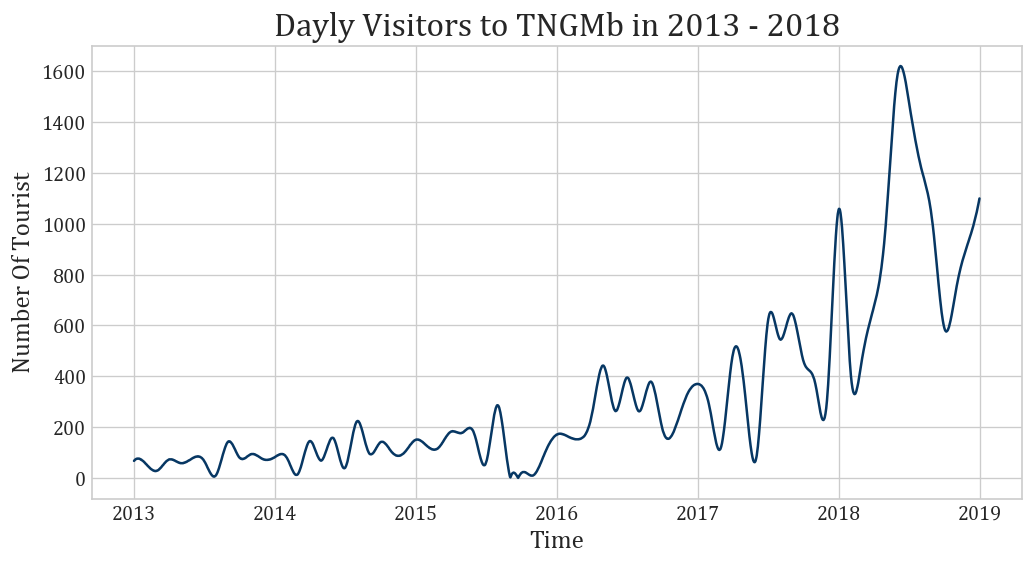

In [5]:
plot_series(series)

In [6]:
# Parameter for tranform and scaling for data sample
n_lag = 1
n_steps_in = 7
n_steps_out = 7
n_test = 358
n_epochs = 3000
n_batch = 1
n_neurons = 7

# create a differenced series
# scale train and test data to [-1, 1]
scaler,train_input, train_output, test_input, test_output = prepare_data_test(series, 
                                                                              n_test, 
                                                                              n_steps_in, 
                                                                              n_steps_out)

In [7]:
print('Train Input sample data point dimensions :',train_input.shape)
print('---------------------------------------------------------------------------')
print('Train Output sample data point dimensions :',train_output.shape)
print('---------------------------------------------------------------------------')
print('Test Input sample data point dimensions :',test_input.shape)
print('---------------------------------------------------------------------------')
print('Test Output sample data point dimensions :',test_output.shape)
print('---------------------------------------------------------------------------')

Train Input sample data point dimensions : (1819, 7, 1)
---------------------------------------------------------------------------
Train Output sample data point dimensions : (1819, 7, 1)
---------------------------------------------------------------------------
Test Input sample data point dimensions : (358, 7, 1)
---------------------------------------------------------------------------
Test Output sample data point dimensions : (358, 7, 1)
---------------------------------------------------------------------------


In [8]:
print('First Row In Sequential Train Input Sample')
print(train_input[1:2])
print('---------------------------------------------------------------------------')
print('First Row In Sequential Train Output Sample')
print(train_output[1:2])

First Row In Sequential Train Input Sample
[[[-0.01639344]
  [ 0.01639344]
  [-0.01639344]
  [-0.01639344]
  [-0.01639344]
  [-0.04918033]
  [-0.01639344]]]
---------------------------------------------------------------------------
First Row In Sequential Train Output Sample
[[[-0.04918033]
  [-0.04918033]
  [-0.04918033]
  [-0.04918033]
  [-0.04918033]
  [-0.08196721]
  [-0.04918033]]]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 7)                    105       
_________________________________________________________________
dense (Dense)                (1, 7)                    56        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00005: early stopping
Time Took :1.48 min


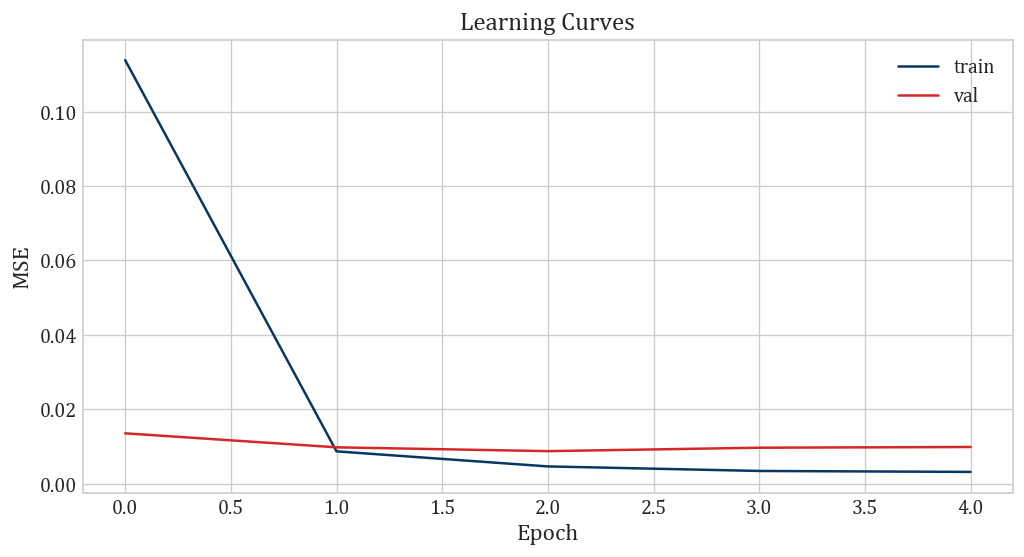

In [9]:
# fit model
model = fit_RNN(train_input, train_output, n_batch, n_epochs, n_neurons)

In [10]:
model = load_model('model-DMM.h5')

In [11]:
# make quarterly prediction (7 days ahead)
forecasts_train = make_forecasts(model, 
                           train_input, 
                           train_output, 
                           n_batch)

# inverse transform forecasts and test
forecasts_train = inverse_transform(series, 
                              forecasts_train, 
                              scaler, 
                              len(train_output)+n_test+6)
actual_train = [row[:] for row in train_output]
actual_train = inverse_transform(series, 
                           actual_train, 
                           scaler, 
                           len(train_output)+n_test+6)

In [12]:
# predicted value on traing samples
pd.DataFrame(forecasts_train).head(9)

,0,1,2,3,4,5,6
0,76.270364,78.949807,79.334365,80.626496,82.665580,84.457628,85.003978
1,78.228817,81.547843,83.766291,86.982915,90.439826,93.796696,96.019243
2,76.965475,79.080170,79.557719,80.956798,82.957908,84.726399,85.316198
3,77.171407,79.574185,80.236677,81.799542,84.161620,86.330494,87.436845
4,77.309993,79.616217,80.982405,83.393228,85.977760,88.498995,90.019232
5,76.743665,78.783349,79.002075,80.250013,82.371211,84.277593,85.214592
6,77.331238,79.891049,81.361217,83.768472,86.927300,89.994118,92.153358
7,75.273062,76.683460,76.505723,77.260742,78.754600,80.090744,80.508054
8,76.080416,78.305075,79.408775,81.670059,84.370767,87.028293,88.897384


In [13]:
# real value on traing samples
pd.DataFrame(actual_train).head(9)

,0,1,2,3,4,5,6
0,76.0,76.0,76.0,76.0,76.0,76.0,75.0
1,76.0,76.0,76.0,76.0,76.0,75.0,75.0
2,76.0,76.0,76.0,76.0,75.0,75.0,74.0
3,76.0,76.0,76.0,75.0,75.0,74.0,73.0
4,76.0,76.0,75.0,75.0,74.0,73.0,72.0
5,76.0,75.0,75.0,74.0,73.0,72.0,72.0
6,75.0,75.0,74.0,73.0,72.0,72.0,70.0
7,75.0,74.0,73.0,72.0,72.0,70.0,69.0
8,74.0,73.0,72.0,72.0,70.0,69.0,68.0


t+1 RMSE: 1.9
t+2 RMSE: 4.9
t+3 RMSE: 6.8
t+4 RMSE: 9.8
t+5 RMSE: 13.3
t+6 RMSE: 17.0
t+7 RMSE: 19.9


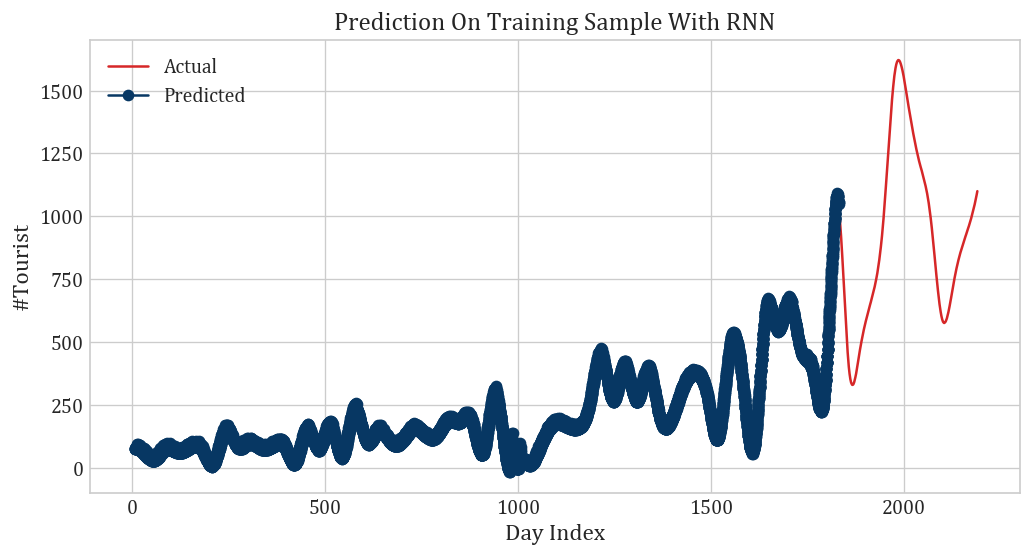

In [14]:
# evaluate forecasts
evaluate_forecasts(actual_train, forecasts_train, n_lag, n_steps_out)
# plot forecasts
plot_forecasts(series, 
               forecasts_train,
               len(train_output)+n_test+6,
               title='Prediction On Training Sample With RNN')

In [15]:
# make quarterly prediction (7 days ahead)
forecasts = make_forecasts(model, 
                           test_input, 
                           test_output, 
                           n_batch)

# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+6)
actual = [row[:] for row in test_output]
actual = inverse_transform(series, actual, scaler, n_test+6)

In [16]:
# predicted value on testing samples
pd.DataFrame(forecasts).head(9)

,0,1,2,3,4,5,6
0,1059.831671,1061.294234,1056.879825,1052.335773,1047.739126,1041.092671,1031.207541
1,1056.639186,1054.595111,1046.853904,1038.521683,1030.196401,1020.099455,1007.200442
2,1053.105597,1048.168615,1039.262786,1029.333193,1018.564989,1006.264189,991.758556
3,1044.765591,1036.515458,1024.781457,1011.265262,996.984224,981.249269,964.175237
4,1035.899476,1025.506769,1012.946372,997.836341,981.716189,964.275018,946.278579
5,1023.186371,1010.284727,996.508789,979.789133,961.705454,942.598688,923.551846
6,1007.234848,992.796859,977.276258,958.770691,939.207649,918.983738,899.315111
7,988.995570,973.042377,957.056651,938.431542,918.283889,898.145480,878.838048
8,969.603868,952.471603,935.371464,916.305759,895.966717,876.135138,857.284817


In [17]:
# real value on testing samples
pd.DataFrame(actual).head(9)

,0,1,2,3,4,5,6
0,1059.0,1057.0,1051.0,1043.0,1032.0,1018.0,1002.0
1,1057.0,1051.0,1043.0,1032.0,1018.0,1002.0,985.0
2,1051.0,1043.0,1032.0,1018.0,1002.0,985.0,965.0
3,1043.0,1032.0,1018.0,1002.0,985.0,965.0,943.0
4,1032.0,1018.0,1002.0,985.0,965.0,943.0,920.0
5,1018.0,1002.0,985.0,965.0,943.0,920.0,896.0
6,1002.0,985.0,965.0,943.0,920.0,896.0,870.0
7,985.0,965.0,943.0,920.0,896.0,870.0,844.0
8,965.0,943.0,920.0,896.0,870.0,844.0,816.0


t+1 RMSE: 2.4
t+2 RMSE: 5.9
t+3 RMSE: 8.4
t+4 RMSE: 11.8
t+5 RMSE: 15.2
t+6 RMSE: 19.2
t+7 RMSE: 22.9


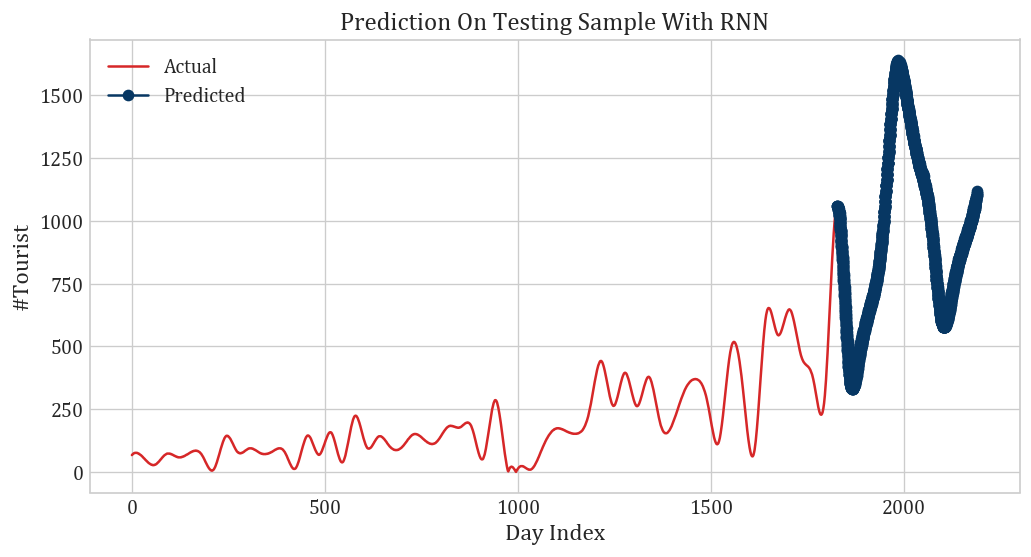

In [18]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_steps_out)
# plot forecasts
plot_forecasts(series, 
               forecasts, 
               n_test+6,
               title='Prediction On Testing Sample With RNN')